# Programma per importare dati da QUADERA #

_Autore: Carlo Roncolato_

_Data: 03/12/2024_

## Definizioni ##

In [1]:
import os
import re
import tkinter as tk
from tkinter import filedialog
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm



formato_data = "%d/%m/%Y %H:%M:%S"  # Specifica il formato della stringa


In [59]:
def leggi_intestazione(file_path):
    # Dizionario per memorizzare i dati estratti
    intestazione = {}
    trovato_separatore = 0
    
    # Apri il file in modalità lettura
    with open(file_path, 'r') as file:
        # Leggi il contenuto del file riga per riga
        for line in file:
            # Rimuovi spazi bianchi iniziali e finali dalla riga
            line = line.strip()

            # Cerca e memorizza i dati con le espressioni regolari
            if line.startswith("Machine Type:"):
                intestazione["MachineType"] = line[13:].strip()  # Estrae il nome di macchina
            elif line.startswith("Date of measure:"):
                intestazione["ExportTime"] = line[16:].strip()   # Estrae la data del file
            elif line.startswith("****"):
                trovato_separatore += 1
                continue
            elif trovato_separatore == 2:
                intestazione["Header"] = line.split(";")
                trovato_separatore = 0
                break

    return intestazione

In [3]:
def seleziona_file():
    # Crea una finestra principale nascosta per il file dialog
    root = tk.Tk()
    root.withdraw()  # Nasconde la finestra principale
    # Apri il file explorer per selezionare un file
    file_path = filedialog.askopenfilename(
        title="Seleziona il file",
        filetypes=[("Text files", "*.asc"), ("All files", "*.*")]
    )
    return file_path

In [79]:
def read_cycles(file_path, intestazione):
   
    i = 0         # inizializza l'indice del blocco
    
    with open(file_path, 'r') as file:
        blocco = {}
        blocco = {"Timestamp": [], "Ureal": [], "Ireal":[]}  # Iniziamo un nuovo blocco
                
        tempo_inizio = 0
        tempo_lettura = 0
        
        lista_U= []
        lista_I = []
        
        for line in tqdm(file, desc="Lettura del file"):
            line = line.strip()
            
            if line.startswith("Running"):
                serie_letture = [elemento.strip() for elemento in line.split(";")]
                if len(serie_letture) != len(intestazione["Header"]):
                    print("Errore: il numero di colonne non corrisponde all'intestazione")
                    break

                # print("Adding block", i)                  
                blocco["Ureal"].append(float(serie_letture[intestazione["Header"].index("U real")]))
                blocco["Ireal"].append(float(serie_letture[intestazione["Header"].index("I real")]))
                timestamp = datetime.strptime(serie_letture[intestazione["Header"].index("Date")] + " " + serie_letture[intestazione["Header"].index("Time")],formato_data)
                blocco["Timestamp"].append(timestamp)                

    return blocco

## Importazione Dati ##

### Selezione del file di input ###

In [7]:
# Esegui il programma con la selezione del file tramite il selettore
# file_path = seleziona_file()
file_path = "./data/TiCleaning.asc"

In [91]:

if os.path.exists(file_path):
    intestazione = leggi_intestazione(file_path)
        
    if intestazione:
        # Stampa i dati estratti
        print("Tipo di Macchina: ", intestazione["MachineType"])
        print("Data Esportazione: ", intestazione["ExportTime"])

    dati = read_cycles(file_path, intestazione)
    print("Numero di letture registrate: ", len(dati["Timestamp"]))
    
                
else:
    print("Nessun file selezionato.")

Tipo di Macchina:  SOLVIX 3k Pulse
Data Esportazione:  14:23:43 - 26 febbraio 2025


Lettura del file: 1507it [00:00, 98026.03it/s]

Errore: il numero di colonne non corrisponde all'intestazione
Numero di letture registrate:  1417


## Visualizzazione ##

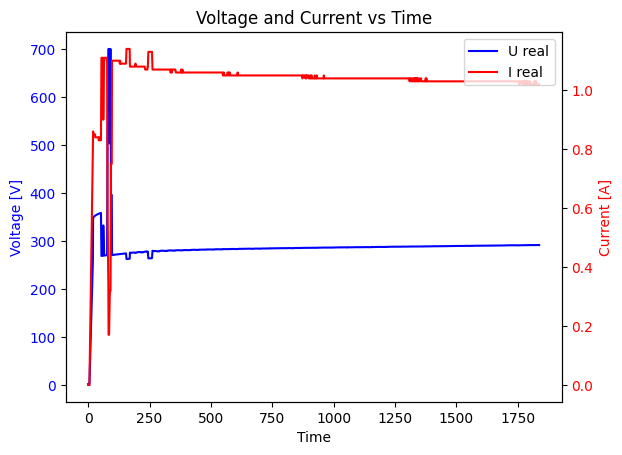

In [99]:
AsseX = [(x - dati["Timestamp"][0]).total_seconds() for x in dati["Timestamp"]]

# Crea la figura e il primo asse
fig, ax1 = plt.subplots()

# Plotta la prima serie (Ureal) sull'asse y primario
ax1.plot(AsseX, dati["Ureal"], 'b-', label='U real')
ax1.set_xlabel('Time')
ax1.set_ylabel('Voltage [V]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Crea un secondo asse y
ax2 = ax1.twinx()

# Plotta la seconda serie (Ireal) sull'asse y secondario
ax2.plot(AsseX, dati["Ireal"], 'r-', label='I real')
ax2.set_ylabel('Current [A]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Aggiungi una legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Voltage and Current vs Time')
plt.show()